In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import operator
import unicodedata
import string
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import confusion_matrix

from string import digits

import warnings
warnings.filterwarnings('ignore')

In [182]:
df = pd.read_csv('sephora_review_db.csv.zip')

In [183]:
# select the top 3 brands with the most number of reviews
new_df = df[(df['brand'] == "bareMinerals") | 
   (df['brand'] == 'tarte') |
  (df['brand'] == 'Laura Mercier')].copy()

In [184]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [185]:
missing_zero_values_table(new_df)

Your selected dataframe has 22 columns and 72385 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
skin_concerns,0,63114,87.2,63114,87.2,object
recommended,1885,61886,85.5,63771,88.1,object
incentivized_review,11812,59993,82.9,71805,99.2,object
skin_type,0,50714,70.1,50714,70.1,object
beauty_insider,0,28814,39.8,28814,39.8,object
location,0,28058,38.8,28058,38.8,object
age,0,27610,38.1,27610,38.1,object
eye_color,0,21678,29.9,21678,29.9,object
skin_tone,0,20308,28.1,20308,28.1,object
user_name,0,1037,1.4,1037,1.4,object


In [186]:
new_df['price'].unique()

array(['$29.00', '$24.00 - $45.00', '$39.00', '$30.00', '$45.00',
       '$48.00', '$34.00', '$14.00 - $37.00', '$36.00', '$42.00',
       '$27.00'], dtype=object)

In [187]:
# convert price column from string to float, replace any range prices with mean price
new_df['price'] = new_df['price'].replace({'$24.00 - $45.00': '34.50'})
new_df['price'] = new_df['price'].replace({'$14.00 - $37.00': '30.50'})
new_df['price'] = new_df['price'].apply(lambda x: x.replace('$',''))
new_df['price'] = new_df['price'].astype(float)

# new_df['price'] = pd.to_numeric(df['price'])
# type(new_df['price'].iloc[0])
type(new_df['price'].iloc[0])

numpy.float64

In [10]:
new_df['recommended'].value_counts()

True     8614
False    1885
Name: recommended, dtype: int64

# NLP subset to create basic model

In [380]:
# nlp_df_test = new_df[['brand', 'name', 'skin_type', 'skin_concerns','review_text', 'recommended']].copy()
nlp_df_test = new_df[['skin_type', 'review_text', 'recommended']].copy()
nlp_df_test.shape

(72385, 3)

In [381]:
format_strings(nlp_df_test, 'review_text', WordNetLemmatizer())

In [382]:
# remove any NAN values
nlp_df_test.dropna(inplace=True)

In [383]:
# replace T/F values in recommended column with 1 (True) or 0 (False)
nlp_df_test['recommended'] = np.where((nlp_df_test['recommended'] == True), 1, 0)

In [385]:
nlp_df_test = nlp_df_test.reset_index(drop=True)

In [386]:
nlp_df_test.index

RangeIndex(start=0, stop=10048, step=1)

In [387]:
tv = TfidfVectorizer()
tfidf = tv.fit_transform(nlp_df_test['review_text']).todense()

In [388]:
bow = tv.get_feature_names()
bow

['aaaaall',
 'aaaamazing',
 'aabsolutely',
 'ab',
 'abduls',
 'abh',
 'ability',
 'able',
 'abnormally',
 'aboutive',
 'aboutskin',
 'absentmindedly',
 'absolute',
 'absolutely',
 'absolutley',
 'absolutly',
 'absorb',
 'absorbed',
 'absorbes',
 'absorbing',
 'absorbmelt',
 'absorbs',
 'abused',
 'abut',
 'abysmal',
 'ac',
 'accent',
 'accentuate',
 'accentuated',
 'accentuates',
 'accentuating',
 'accept',
 'acceptable',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accidently',
 'accolade',
 'accommodate',
 'accompanies',
 'accompanying',
 'accomplish',
 'accomplishes',
 'according',
 'accordingly',
 'account',
 'accumulate',
 'accumulated',
 'accumulating',
 'accurate',
 'accustomed',
 'accutane',
 'ace',
 'aceite',
 'acengenic',
 'ache',
 'achieve',
 'achieved',
 'achieves',
 'achieving',
 'achne',
 'acid',
 'acne',
 'acneacne',
 'acneblemishes',
 'acnebumps',
 'acneclearing',
 'acnecovers',
 'acnedarkspots',
 'acnediscoloration',
 'acnefighting',
 'acnegenic',
 'acnei',
 

In [389]:
nlp_df_tdidf = pd.DataFrame(tfidf, columns=bow)
nlp_df_tdidf.index

RangeIndex(start=0, stop=10048, step=1)

In [390]:
nlp_test2 = nlp_df_test.merge(nlp_df_tdidf, left_index=True, right_index=True)
nlp_test2.head()

,skin_type,review_text,recommended_x,aaaaall,aaaamazing,aabsolutely,ab,abduls,abh,ability,...,yuk,yup,zap,zebra,zero,zinc,zit,zombie,zombiefied,zone
0,combination,using product almost decade every time try som...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,oily,big fan fairer side acne sometimes hard get le...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,combination,love bare mineral original foundation powder b...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,combination,lem first start saying used love foundation wo...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,combination,one first foundation ever bought liked first m...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [391]:
nlp_test2.drop(columns=['review_text'], inplace=True)
nlp_test2.head()

,skin_type,recommended_x,aaaaall,aaaamazing,aabsolutely,ab,abduls,abh,ability,able,...,yuk,yup,zap,zebra,zero,zinc,zit,zombie,zombiefied,zone
0,combination,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,oily,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,combination,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,combination,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,combination,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [393]:
skin_type_dummies = pd.get_dummies(nlp_test2['skin_type'])
skin_type_dummies.head()

,combination,dry,normal,oily
0,1,0,0,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [407]:
final_test = pd.concat([nlp_test2, skin_type_dummies], axis=1)
final_test.drop(columns=['skin_type'], inplace=True)
final_test.head()

,recommended_x,aaaaall,aaaamazing,aabsolutely,ab,abduls,abh,ability,able,abnormally,...,zero,zinc,zit,zombie,zombiefied,zone,combination,dry,normal,oily
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


In [408]:
# X = new dataframe minus recommended column
y = final_test.pop('recommended_x')
X = final_test.values

In [409]:
logistic = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [411]:
print(precision)
print(accuracy)
print(recall)

0.8853109836788707
0.8829617834394905
0.9833414992650662


In [412]:
def modelling(X, y, model):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    probs = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)
    
    return precision, accuracy, recall, thresh_df, roc_auc, model

In [417]:
modelling(X, y, LogisticRegression())

(0.8920229175848391,
 0.8941082802547771,
 0.9897310513447433,
           prob  y   tn    fn   fp    tp       fpr       tpr  precision
 0     0.023864  0    1     0  466  2045  0.997859  1.000000   0.814417
 1     0.027080  0    2     0  465  2045  0.995717  1.000000   0.814741
 2     0.032841  0    3     0  464  2045  0.993576  1.000000   0.815066
 3     0.033807  0    4     0  463  2045  0.991435  1.000000   0.815391
 4     0.046083  0    5     0  462  2045  0.989293  1.000000   0.815716
 5     0.046196  0    6     0  461  2045  0.987152  1.000000   0.816042
 6     0.054166  0    7     0  460  2045  0.985011  1.000000   0.816367
 7     0.057530  0    8     0  459  2045  0.982869  1.000000   0.816693
 8     0.058590  0    9     0  458  2045  0.980728  1.000000   0.817020
 9     0.064818  0   10     0  457  2045  0.978587  1.000000   0.817346
 10    0.069391  0   11     0  456  2045  0.976445  1.000000   0.817673
 11    0.077606  0   12     0  455  2045  0.974304  1.000000   0.818000
 

In [416]:
GB = GradientBoostingClassifier(n_estimators=300, max_depth=10, learning_rate=.01)

modelling(X, y, GB)

(0.8674080410607357,
 0.865047770700637,
 0.9859017987360233,
           prob  y   tn    fn   fp    tp       fpr       tpr  precision
 0     0.075487  0    1     0  454  2057  0.997802  1.000000   0.819196
 1     0.079441  0    2     0  453  2057  0.995604  1.000000   0.819522
 2     0.083550  0    3     0  452  2057  0.993407  1.000000   0.819849
 3     0.084555  0    4     0  451  2057  0.991209  1.000000   0.820175
 4     0.085320  0    5     0  450  2057  0.989011  1.000000   0.820503
 5     0.096482  0    6     0  449  2057  0.986813  1.000000   0.820830
 6     0.098176  0    7     0  448  2057  0.984615  1.000000   0.821158
 7     0.103107  0    8     0  447  2057  0.982418  1.000000   0.821486
 8     0.107667  0    9     0  446  2057  0.980220  1.000000   0.821814
 9     0.127790  0   10     0  445  2057  0.978022  1.000000   0.822142
 10    0.132053  0   11     0  444  2057  0.975824  1.000000   0.822471
 11    0.136850  0   12     0  443  2057  0.973626  1.000000   0.822800
 1

In [148]:
nlp_df_sub = new_df[['review_text', 'recommended']].copy()
nlp_df_sub.head()

,review_text,recommended
43998,Bare Minerals is great. I just recently starte...,NaN
43999,I can not say anything bad about this. I'm liv...,NaN
44000,I don't get what is so special about this prod...,NaN
44001,First I want to start off by saying that this ...,NaN
44002,I've been using this powder foundation for yea...,NaN


In [149]:
# remove any NAN values
nlp_df_sub.dropna(inplace=True)

In [151]:
# replace T/F values in recommended column with 1 (True) or 0 (False)
nlp_df_sub['recommended'] = np.where((nlp_df_sub['recommended'] == True), 1, 0)

In [286]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
#     return only_ascii.decode()
    return nfkd_form

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_nums(text):
    '''remove numbers from string'''
    remove_digits = str.maketrans('', '', digits)
    no_digits = text.translate(remove_digits)
    return no_digits

import string
punctuation_ = set(string.punctuation)

from nltk.corpus import stopwords

stopwords_ = set(stopwords.words('english'))

In [145]:
# use to compare stems before putting into model
def compare_stems(df, col_name):
    porter = PorterStemmer()
    snowball = SnowballStemmer('english')
    wordnet = WordNetLemmatizer()
    
    df[col_name] = [remove_accents(row) for row in df[col_name]]
    df[col_name] = [remove_nums(row) for row in df[col_name]]
    df[col_name] = [strip_html_tags(row) for row in df[col_name]]
    df[col_name] = df[col_name].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    df[col_name] = [word_tokenize(row.lower()) for row in df[col_name]]
    df[col_name] = [[word for word in row if not word in stopwords_ and not word in punctuation_]
                   for row in df[col_name]]
    
    docs_porter = df[col_name].apply(lambda row: ' '.join([porter.stem(word) for word in row]))
    docs_snowball = df[col_name].apply(lambda row: ' '.join([snowball.stem(word) for word in row]))
    docs_wordnet = df[col_name].apply(lambda row: ' '.join([wordnet.lemmatize(word) for word in row]))
    
    stem_data = {'porter': docs_porter[:5], 'snowball': docs_snowball[:5], 'lemmatize': docs_wordnet[:5]}
    
    stem_df = pd.DataFrame(stem_data, columns=['porter', 'snowball', 'lemmatize'])
    
    return stem_df

In [146]:
compare_stems(nlp_df_sub, 'review_text')

,porter,snowball,lemmatize
44128,use product almost decad everi time tri someth...,use product almost decad everi time tri someth...,using product almost decade every time try som...
44142,big fan fairer side acn sometim hard get level...,big fan fairer side acn sometim hard get level...,big fan fairer side acne sometimes hard get le...
44176,love bare miner origin foundat powder began us...,love bare miner origin foundat powder began us...,love bare mineral original foundation powder b...
44218,lem first start say use love foundat would swe...,lem first start say use love foundat would swe...,lem first start saying used love foundation wo...
44221,one first foundat ever bought like first make ...,one first foundat ever bought like first make ...,one first foundation ever bought liked first m...


In [291]:
# use to format strings before putting into model after deciding to stem or not
def format_strings(df, col_name, stemming):
    stemmer = stemming
    df[col_name] = [remove_accents(row) for row in df[col_name]]
    df[col_name] = [remove_nums(row) for row in df[col_name]]
    df[col_name] = [strip_html_tags(row) for row in df[col_name]]
    df[col_name] = df[col_name].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    df[col_name] = [word_tokenize(row.lower()) for row in df[col_name]]
    df[col_name] = [[word for word in row if not word in stopwords_ and not word in punctuation_]
                   for row in df[col_name]]
    # adjust based on stemming chosen
    df[col_name] = df[col_name].apply(lambda row: ' '.join([stemmer.lemmatize(word) for word in row]))

In [154]:
format_strings(nlp_df_sub, 'review_text', WordNetLemmatizer())

In [155]:
nlp_df_sub.head()

,review_text,recommended
44128,using product almost decade every time try som...,1
44142,big fan fairer side acne sometimes hard get le...,1
44176,love bare mineral original foundation powder b...,1
44218,lem first start saying used love foundation wo...,0
44221,one first foundation ever bought liked first m...,0


In [156]:
def w_freq(text_series):
    countvect = CountVectorizer()
    bag_of_words = countvect.fit_transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in countvect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [157]:
#  vectorizers
tfidf = TfidfVectorizer()
countvect = CountVectorizer()

# models
logistic = LogisticRegression()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

GNB = GaussianNB()
MNB = MultinomialNB()
BNB = BernoulliNB()

In [158]:
y = nlp_df_sub['recommended']

In [159]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df

In [160]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

In [161]:
def modelling(text_series, y, vectorizer, model):
    # declare X
    X = vectorizer.fit_transform(text_series)
    
    if model.__class__.__name__ == 'GaussianNB':
        X = X.toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    probs = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)
    
    return precision, accuracy, recall, thresh_df, roc_auc, model

In [162]:
logistic_mod = modelling(nlp_df_sub['review_text'], y, TfidfVectorizer(), LogisticRegression())

In [163]:
def print_precision_acc_recall(df, text_series, model):
    print('Precision for {} is {:.2f}'.format(modelling(df[text_series], y, TfidfVectorizer(), model)[5].__class__.__name__,
                                                modelling(nlp_df['review_text'], y, TfidfVectorizer(), model)[0]))
    print('Accuracy for {} is {:.2f}'.format(modelling(df[text_series], y, TfidfVectorizer(), model)[5].__class__.__name__,
                                                modelling(nlp_df['review_text'], y, TfidfVectorizer(), model)[1]))
    print('Recall for {} is {:.2f}'.format(modelling(df[text_series], y, TfidfVectorizer(), model)[5].__class__.__name__,
                                                modelling(nlp_df['review_text'], y, TfidfVectorizer(), model)[2]))

In [164]:
def get_conf_matrix(text_series, y, vectorizer, model):
    # declare X
    X = vectorizer.fit_transform(text_series)
    
    if model.__class__.__name__ == 'GaussianNB':
        X = X.toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))

In [165]:
model_list = [logistic, gb, rf, dt, BNB]

In [166]:
# plot multiple rocs for NLP
def plot_multiple_rocs(model_list, text_series, y, vectorizer):
    ax.plot([0,1],[0,1], 'k', label="random")
    for model in model_list:
        results = modelling(text_series, y, vectorizer, model)
        auc_score = results[4]
        plot_roc(ax, results[3], '{} AUC {}'.format(model.__class__.__name__, round(auc_score, 3)))

In [194]:
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
#     ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

In [198]:
# plot multiple precision recall curves
def plot_multiple_prec_recall(model_list, text_series, y, vectorizer):
    fig, ax = plt.subplots(figsize=(15,8))
#     ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    for model in model_list:
        results = modelling(text_series, y, vectorizer, model)
        thresh_df = results[3]
        plot_precision_recall(ax, thresh_df)

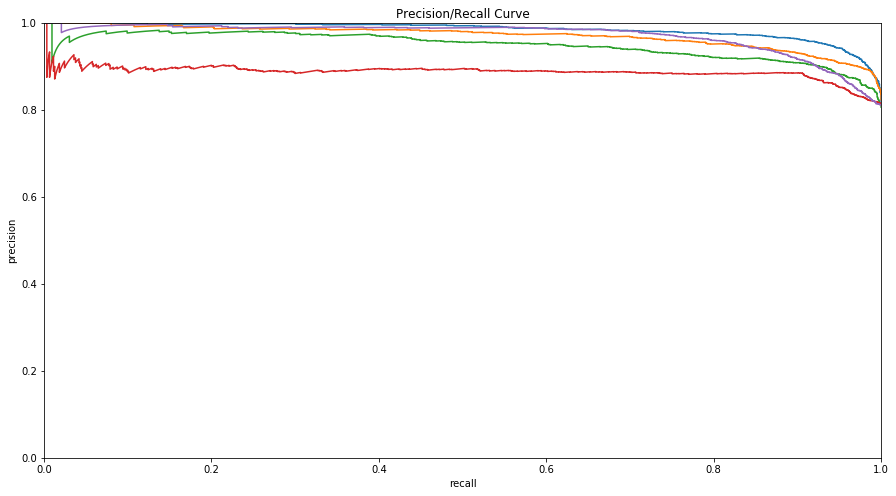

In [199]:
plot_multiple_prec_recall(model_list, nlp_df_sub['review_text'], y, TfidfVectorizer())

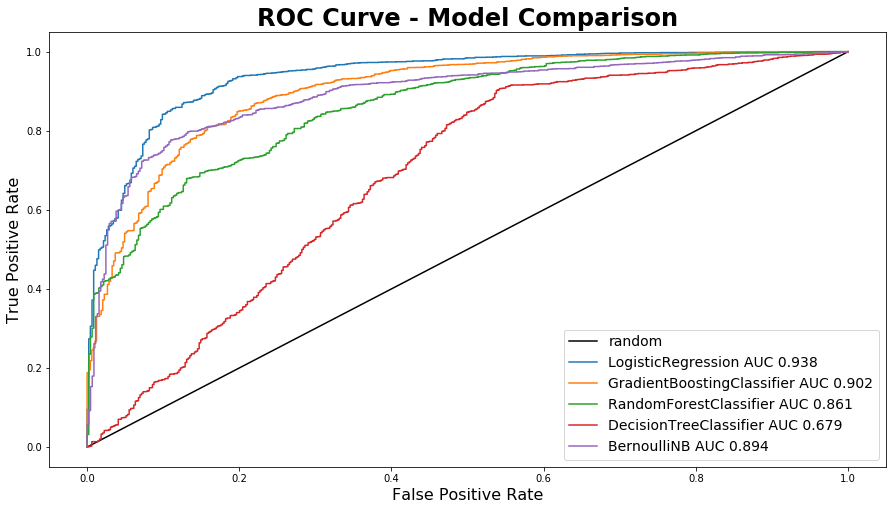

In [170]:
fig, ax = plt.subplots(figsize=(15,8))
plot_multiple_rocs(model_list, nlp_df_sub['review_text'], y, TfidfVectorizer())

In [171]:
print_precision_acc_recall(nlp_df_sub, 'review_text', LogisticRegression())

Precision for LogisticRegression is 0.91
Accuracy for LogisticRegression is 0.90
Recall for LogisticRegression is 0.98


In [172]:
get_conf_matrix(nlp_df_sub['review_text'], y, TfidfVectorizer(), LogisticRegression())

[[ 242  222]
 [  37 2124]]


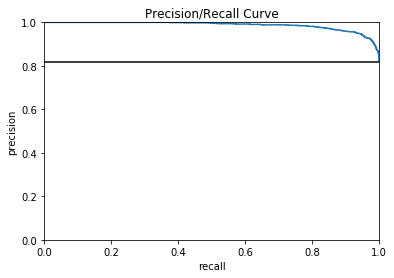

In [191]:
thresh_df = logistic_mod[3]
fig, ax = plt.subplots()
plot_precision_recall(ax, thresh_df)

In [174]:
# create wordcloud
def create_wordcloud(df, col_name):
    text = ' '.join(review for review in df[col_name])
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')

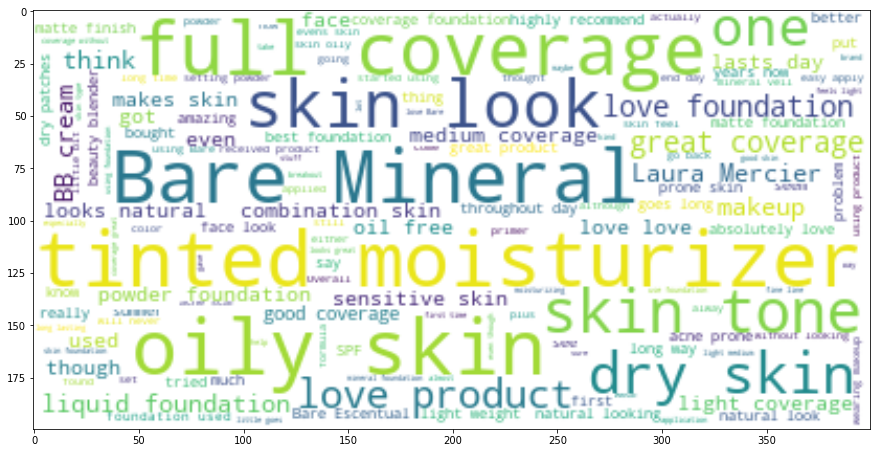

In [36]:
create_wordcloud(new_df, 'review_text')
plt.savefig('imgs/WordCloud1')

# Removed NA values from dataset for model 2 

In [222]:
df_no_na = df.dropna(subset=['skin_concerns', 'skin_tone', 'skin_type'])
df_no_na.shape

(70722, 22)

In [223]:
df_no_na['recommended'] = np.where((df_no_na['recommended'] == True), 1, 0)

In [224]:
# convert price column from string to float, replace any range prices with mean price
df_no_na['price'] = df_no_na['price'].replace({'$19.00 - $43.00': '31.0'})
df_no_na['price'] = df_no_na['price'].replace({'$42.00 - $64.00': '53.0'})
df_no_na['price'] = df_no_na['price'].replace({'$15.00 - $38.00': '26.5'})
df_no_na['price'] = df_no_na['price'].replace({'$24.00 - $45.00': '34.5'})
df_no_na['price'] = df_no_na['price'].replace({'$14.00 - $37.00': '25.5'})
df_no_na['price'] = df_no_na['price'].replace({'$15.00 - $60.00': '37.5'})
df_no_na['price'] = df_no_na['price'].replace({'$15.00 - $28.00': '21.5'})
df_no_na['price'] = df_no_na['price'].replace({'$50.00 - $52.00': '51.0'})
df_no_na['price'] = df_no_na['price'].replace({'$10.00 - $29.00': '19.5'})
df_no_na['price'] = df_no_na['price'].replace({'$20.00 - $36.00': '28.0'})
df_no_na['price'] = df_no_na['price'].replace({'$22.00 - $60.00': '28.0'})
df_no_na['price'] = df_no_na['price'].replace({'$20.00 - $36.00': '41.0'})
df_no_na['price'] = df_no_na['price'].replace({'$47.00 - $49.00': '48.0'})
df_no_na['price'] = df_no_na['price'].replace({'$45.00 - $50.00': '47.5'})
df_no_na['price'] = df_no_na['price'].replace({'$42.00 - $43.00': '42.5'})
df_no_na['price'] = df_no_na['price'].replace({'$18.00 - $35.00': '26.5'})


df_no_na['price'] = df_no_na['price'].apply(lambda x: x.replace('$',''))
df_no_na['price'] = df_no_na['price'].astype(float)

type(df_no_na['price'].iloc[0])

numpy.float64

In [225]:
df_no_na.head()

,brand,name,brand_id,brand_image_url,product_id,product_image_url,rating,skin_type,eye_color,skin_concerns,...,age,beauty_insider,user_name,review_text,price,recommended,first_submission_date,last_submission_date,location,description
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,4,oily,brown,acne,...,NaN,NaN,serena2304,Really good foundation I like it a lot but som...,34.0,1,2018-01-06T01:04:26.000+00:00,2018-12-08T05:44:51.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
1,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,acne,...,NaN,NaN,emilyrerwin,"As someone who is very VERY fair, I have alway...",34.0,1,2018-10-19T00:29:37.000+00:00,2018-12-07T15:16:13.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,darkCircles,...,NaN,NaN,BrowniexVixen,First purchase of a foundation of any kind. Wa...,34.0,1,2018-02-05T21:40:40.000+00:00,2018-12-08T19:07:33.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
3,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,brown,acne,...,NaN,NaN,KoKoDior,I absolutely love this foundation! I get compl...,34.0,1,2018-05-09T00:32:04.000+00:00,2018-12-03T09:54:03.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."
4,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,6200,/contentimages/brands/fentybeauty/logo.jpg,P87985432,https://www.sephora.com/productimages/sku/s192...,5,combination,green,darkCircles,...,NaN,NaN,kristaloveee,Love this foundation! I was using Too Faced Bo...,34.0,1,2018-12-03T00:40:58.000+00:00,2018-12-06T02:32:21.000+00:00,NaN,"What it is: A soft-matte, long-wear foundation..."


In [226]:
nlp_df = df_no_na[['review_text', 'recommended']].copy()

In [227]:
nlp_df.shape

(70722, 2)

In [221]:
# compare stems, see which one seems best
compare_stems(nlp_df, 'review_text')

,porter,snowball,lemmatize
0,realli good foundat like lot sometim grab dri ...,realli good foundat like lot sometim grab dri ...,really good foundation like lot sometimes grab...
1,someon fair alway hard time find foundat right...,someon fair alway hard time find foundat right...,someone fair always hard time finding foundati...
2,first purchas foundat kind will give tri caus ...,first purchas foundat kind will give tri caus ...,first purchase foundation kind willing give tr...
3,absolut love foundat get compliment daili skin...,absolut love foundat get compliment daili skin...,absolutely love foundation get compliment dail...
4,love foundat use face born way bought beauti t...,love foundat use face born way bought beauti t...,love foundation using faced born way bought be...


In [228]:
# format strings for df
format_strings(nlp_df, 'review_text', WordNetLemmatizer())

In [229]:
y = nlp_df['recommended']

In [231]:
nlp_df.shape

(70722, 2)

In [232]:
model_list = [logistic, gb, rf, dt, BNB]

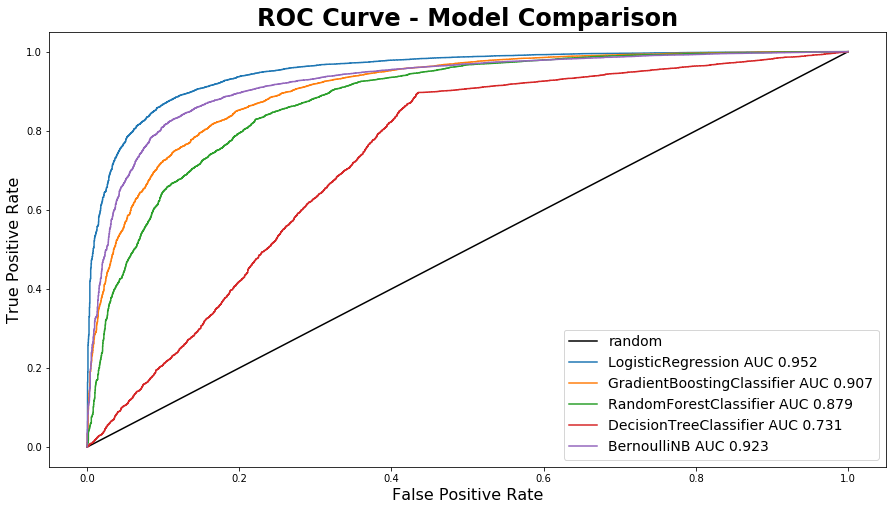

In [234]:
fig, ax = plt.subplots(figsize=(15,8))
plot_multiple_rocs(model_list, nlp_df['review_text'], y, TfidfVectorizer())

In [239]:
print_precision_acc_recall(nlp_df, 'review_text', RandomForestClassifier())

Precision for RandomForestClassifier is 0.88
Accuracy for RandomForestClassifier is 0.87
Recall for RandomForestClassifier is 0.97


In [238]:
get_conf_matrix(nlp_df['review_text'], y, TfidfVectorizer(), LogisticRegression())

[[ 2528  1119]
 [  463 13571]]
